# Object Detection with YOLOv8 (+ how to convert our own dataset to yolo format) (estimated time 20-30 mins)
<br>Last updated on 29/08/2024</br>
    <br>We aim to detect objects consisting of 20 classes: person, bird, cat, dog, horse, sheep, aeroplane, bicycle, boat, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, and TV monitor. **Pascal VOC Detection Dataset** (http://host.robots.ox.ac.uk/pascal/VOC/) and **YOLOv8** (https://docs.ultralytics.com/datasets/detect/voc/) are employed for the trial. The code is modified form https://colab.research.google.com/github/ultralytics/ultralytics/blob/main/examples/tutorial.ipynb. <br>

     from previous notebook we using their dataset that been set up for yolo. now, we will learn about custom our own dataset.


In [78]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.83 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.7/78.2 GB disk)


## Download Pascal-VOC 2007 dataset

In [1]:
# Import necessary libraries
import os
import requests
import tarfile
from tqdm import tqdm

In [2]:
def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    filename = os.path.join(dest_folder, url.split('/')[-1])

    if os.path.isfile(filename):
        print(f"{filename} already exists. Skipping download.")
        return filename

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as f, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))

    return filename

def extract_tar(tar_file, extract_to_folder):
    with tarfile.open(tar_file, 'r') as tar_ref:
        tar_ref.extractall(extract_to_folder)

In [28]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
# Download and extract VOC 2007
base_url = "http://host.robots.ox.ac.uk:8080/pascal/VOC/voc2007/"
files = {
    'VOCtrainval_06-Nov-2007.tar': 'VOCtrainval_06-Nov-2007.tar',
    'VOCtest_06-Nov-2007.tar': 'VOCtest_06-Nov-2007.tar'
}

download_folder = '/content/voc2007'
for url, filename in files.items():
    print(f"Downloading {filename}...")
    tar_path = download_file(base_url + filename, download_folder)
    print(f"Extracting {filename}...")
    extract_tar(tar_path, download_folder)
    print(f"{filename} extracted.")

/content/voc2007/VOCtrainval_06-Nov-2007.tar: 100%|██████████| 439M/439M [00:21<00:00, 21.3MiB/s]


Extracting VOCtrainval_06-Nov-2007.tar...
VOCtrainval_06-Nov-2007.tar extracted.


/content/voc2007/VOCtest_06-Nov-2007.tar: 100%|██████████| 430M/430M [00:18<00:00, 24.7MiB/s]


Extracting VOCtest_06-Nov-2007.tar...
VOCtest_06-Nov-2007.tar extracted.


## Convert VOC format (.xml) to Yolo format (.yaml)

In [30]:
import os
import cv2
import xml.etree.ElementTree as ET
from glob import glob
from sklearn.model_selection import train_test_split
import shutil

**To train yolo on custom dataset** we need to setup dataset to  thier structure <br>
( that can see in /content/yolo_annotations) <br>

---

**Yolo .yaml file** need dataset folder that contains <br>
1. train folder <br>
2. val folder <br>

>**Yolo directory** <br>
dataset/<br>
├── images/ <br>
│  &emsp; ├── train/ <br>
│  &emsp;  &emsp; &emsp; ├── 000001.jpg (original image)<br>
│  &emsp; └── val/ <br>
└── labels/ <br>
 &ensp;  &emsp; ├── train/ <br>
 &ensp;  &emsp; └── val/ <br>
 &ensp; &emsp;  &emsp; &emsp; ├── 000001.txt (annotation)<br>


each line of text file is a object that contain: <br>
 **{class x_center y_center width height}** <br>

The example of 000001.txt: <br>
5 0.34419263456090654 0.611 0.4164305949008499 0.262 <br>
0 0.509915014164306 0.51 0.9745042492917847 0.972


In [45]:
# Define your class names (must match your dataset)
class_names = ["person", "car", "bus", "train", "cat", "dog", "horse", "cow", "sheep", "aeroplane", "motorbike", "sofa", "tvmonitor", "bottle", "chair", "table", "pottedplant"]

voc_annot_folder = '/content/voc2007/VOCdevkit/VOC2007/Annotations'
image_folder = '/content/voc2007/VOCdevkit/VOC2007/JPEGImages'
yolo_annot_folder = '/content/yolo_annotations'

In [50]:
os.makedirs(yolo_annot_folder,exist_ok=True)
os.makedirs(os.path.join(yolo_annot_folder,"images"),exist_ok=True)
os.makedirs(os.path.join(yolo_annot_folder,"labels"),exist_ok=True)
# Create lists for images
image_paths = glob(os.path.join(image_folder, "*.jpg"))
image_filenames = [os.path.basename(path) for path in image_paths]

# Process training and validation annotations
train_annot_folder = os.path.join(yolo_annot_folder, "labels", 'train')
val_annot_folder = os.path.join(yolo_annot_folder, "labels" ,'val')

os.makedirs(train_annot_folder,exist_ok=True)
os.makedirs(val_annot_folder,exist_ok=True)

In [51]:
# Helper function to process annotations
def process_annotations(file_list, annot_folder):
    for image_filename in file_list:
        xml_file = os.path.join(voc_annot_folder, os.path.splitext(image_filename)[0] + '.xml')
        if not os.path.isfile(xml_file):
            continue

        tree = ET.parse(xml_file)
        root = tree.getroot()

        # Get image size
        image_path = os.path.join(image_folder, image_filename)
        image = cv2.imread(image_path)
        h, w, _ = image.shape

        yolo_annot_file = os.path.join(annot_folder, os.path.splitext(image_filename)[0] + '.txt')
        with open(yolo_annot_file, 'w') as f:
            for obj in root.findall('object'):
                cls = obj.find('name').text
                if cls not in class_names:
                    continue
                cls_id = class_names.index(cls)

                xml_box = obj.find('bndbox')
                b = [int(xml_box.find('xmin').text), int(xml_box.find('ymin').text), int(xml_box.find('xmax').text), int(xml_box.find('ymax').text)]

                # Convert to YOLO format
                x_center = (b[0] + b[2]) / 2.0 / w
                y_center = (b[1] + b[3]) / 2.0 / h
                width = (b[2] - b[0]) / w
                height = (b[3] - b[1]) / h

                f.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")


In [52]:
# Split dataset into training and validation
train_files, val_files = train_test_split(image_filenames, test_size=0.2, random_state=42)

In [53]:
process_annotations(train_files, train_annot_folder)
process_annotations(val_files, val_annot_folder)

In [66]:
# Copy images to respective folders
train_img_folder = os.path.join(yolo_annot_folder, "images", 'train')
val_img_folder = os.path.join(yolo_annot_folder, "images" ,'val')

os.makedirs(train_img_folder,exist_ok=True)
os.makedirs(val_img_folder,exist_ok=True)

for f in train_files:
    shutil.copy(os.path.join(image_folder, f), os.path.join(train_img_folder, f))

for f in val_files:
    shutil.copy(os.path.join(image_folder, f), os.path.join(val_img_folder, f))

In [63]:
# Create data.yaml file
yaml_content = """
train: /content/yolo_annotations/images/train
val: /content/yolo_annotations/images/val

nc: 17  # Number of classes (change this if your class list differs)
names: ['person', 'car', 'bus', 'train', 'cat', 'dog', 'horse', 'cow', 'sheep', 'aeroplane', 'motorbike', 'sofa', 'tvmonitor', 'bottle', 'chair', 'table', 'pottedplant']
"""

with open('/content/data.yaml', 'w') as f:
    f.write(yaml_content)

In [68]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model.to('cuda:0') # set up the model to GPU
# Use the model
results = model.train(data='data.yaml', epochs=3)  # train the model

engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fals

train: Scanning /content/yolo_annotations/labels/train... 7970 images, 743 backgrounds, 0 corrupt: 100%|██████████| 7970/7970 [00:07<00:00, 1133.13it/s]


train: New cache created: /content/yolo_annotations/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/yolo_annotations/labels/val... 1993 images, 192 backgrounds, 0 corrupt: 100%|██████████| 1993/1993 [00:02<00:00, 952.87it/s] 


val: New cache created: /content/yolo_annotations/labels/val.cache
Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000476, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train9
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      2.58G      1.078      2.395      1.276          9        640: 100%|██████████| 499/499 [02:56<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:18<00:00,  3.37it/s]


                   all       1993       5437      0.677      0.623      0.674      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      2.46G      1.102      1.723      1.298          9        640: 100%|██████████| 499/499 [02:53<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


                   all       1993       5437      0.682       0.62      0.674      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      2.44G      1.066      1.576       1.27          5        640: 100%|██████████| 499/499 [02:48<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:20<00:00,  3.02it/s]


                   all       1993       5437       0.75      0.657      0.727      0.498

3 epochs completed in 0.162 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.2MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics YOLOv8.2.83 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,008,963 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


                   all       1993       5437      0.751      0.658      0.728      0.498
                person        813       2116      0.788      0.773      0.844       0.56
                   car        312        644      0.789      0.755      0.814      0.586
                   bus         76        113      0.814      0.622      0.709      0.545
                 train        109        127      0.869      0.795      0.877      0.625
                   cat        113        121      0.754      0.719      0.814       0.57
                   dog        181        223      0.714      0.668      0.722      0.506
                 horse        119        182      0.821      0.753      0.835        0.6
                   cow         64        161      0.847       0.59      0.731      0.505
                 sheep         34         77      0.597      0.688      0.664      0.426
             aeroplane        103        156      0.675      0.801      0.808      0.543
             motorbik

In [71]:
from PIL import Image

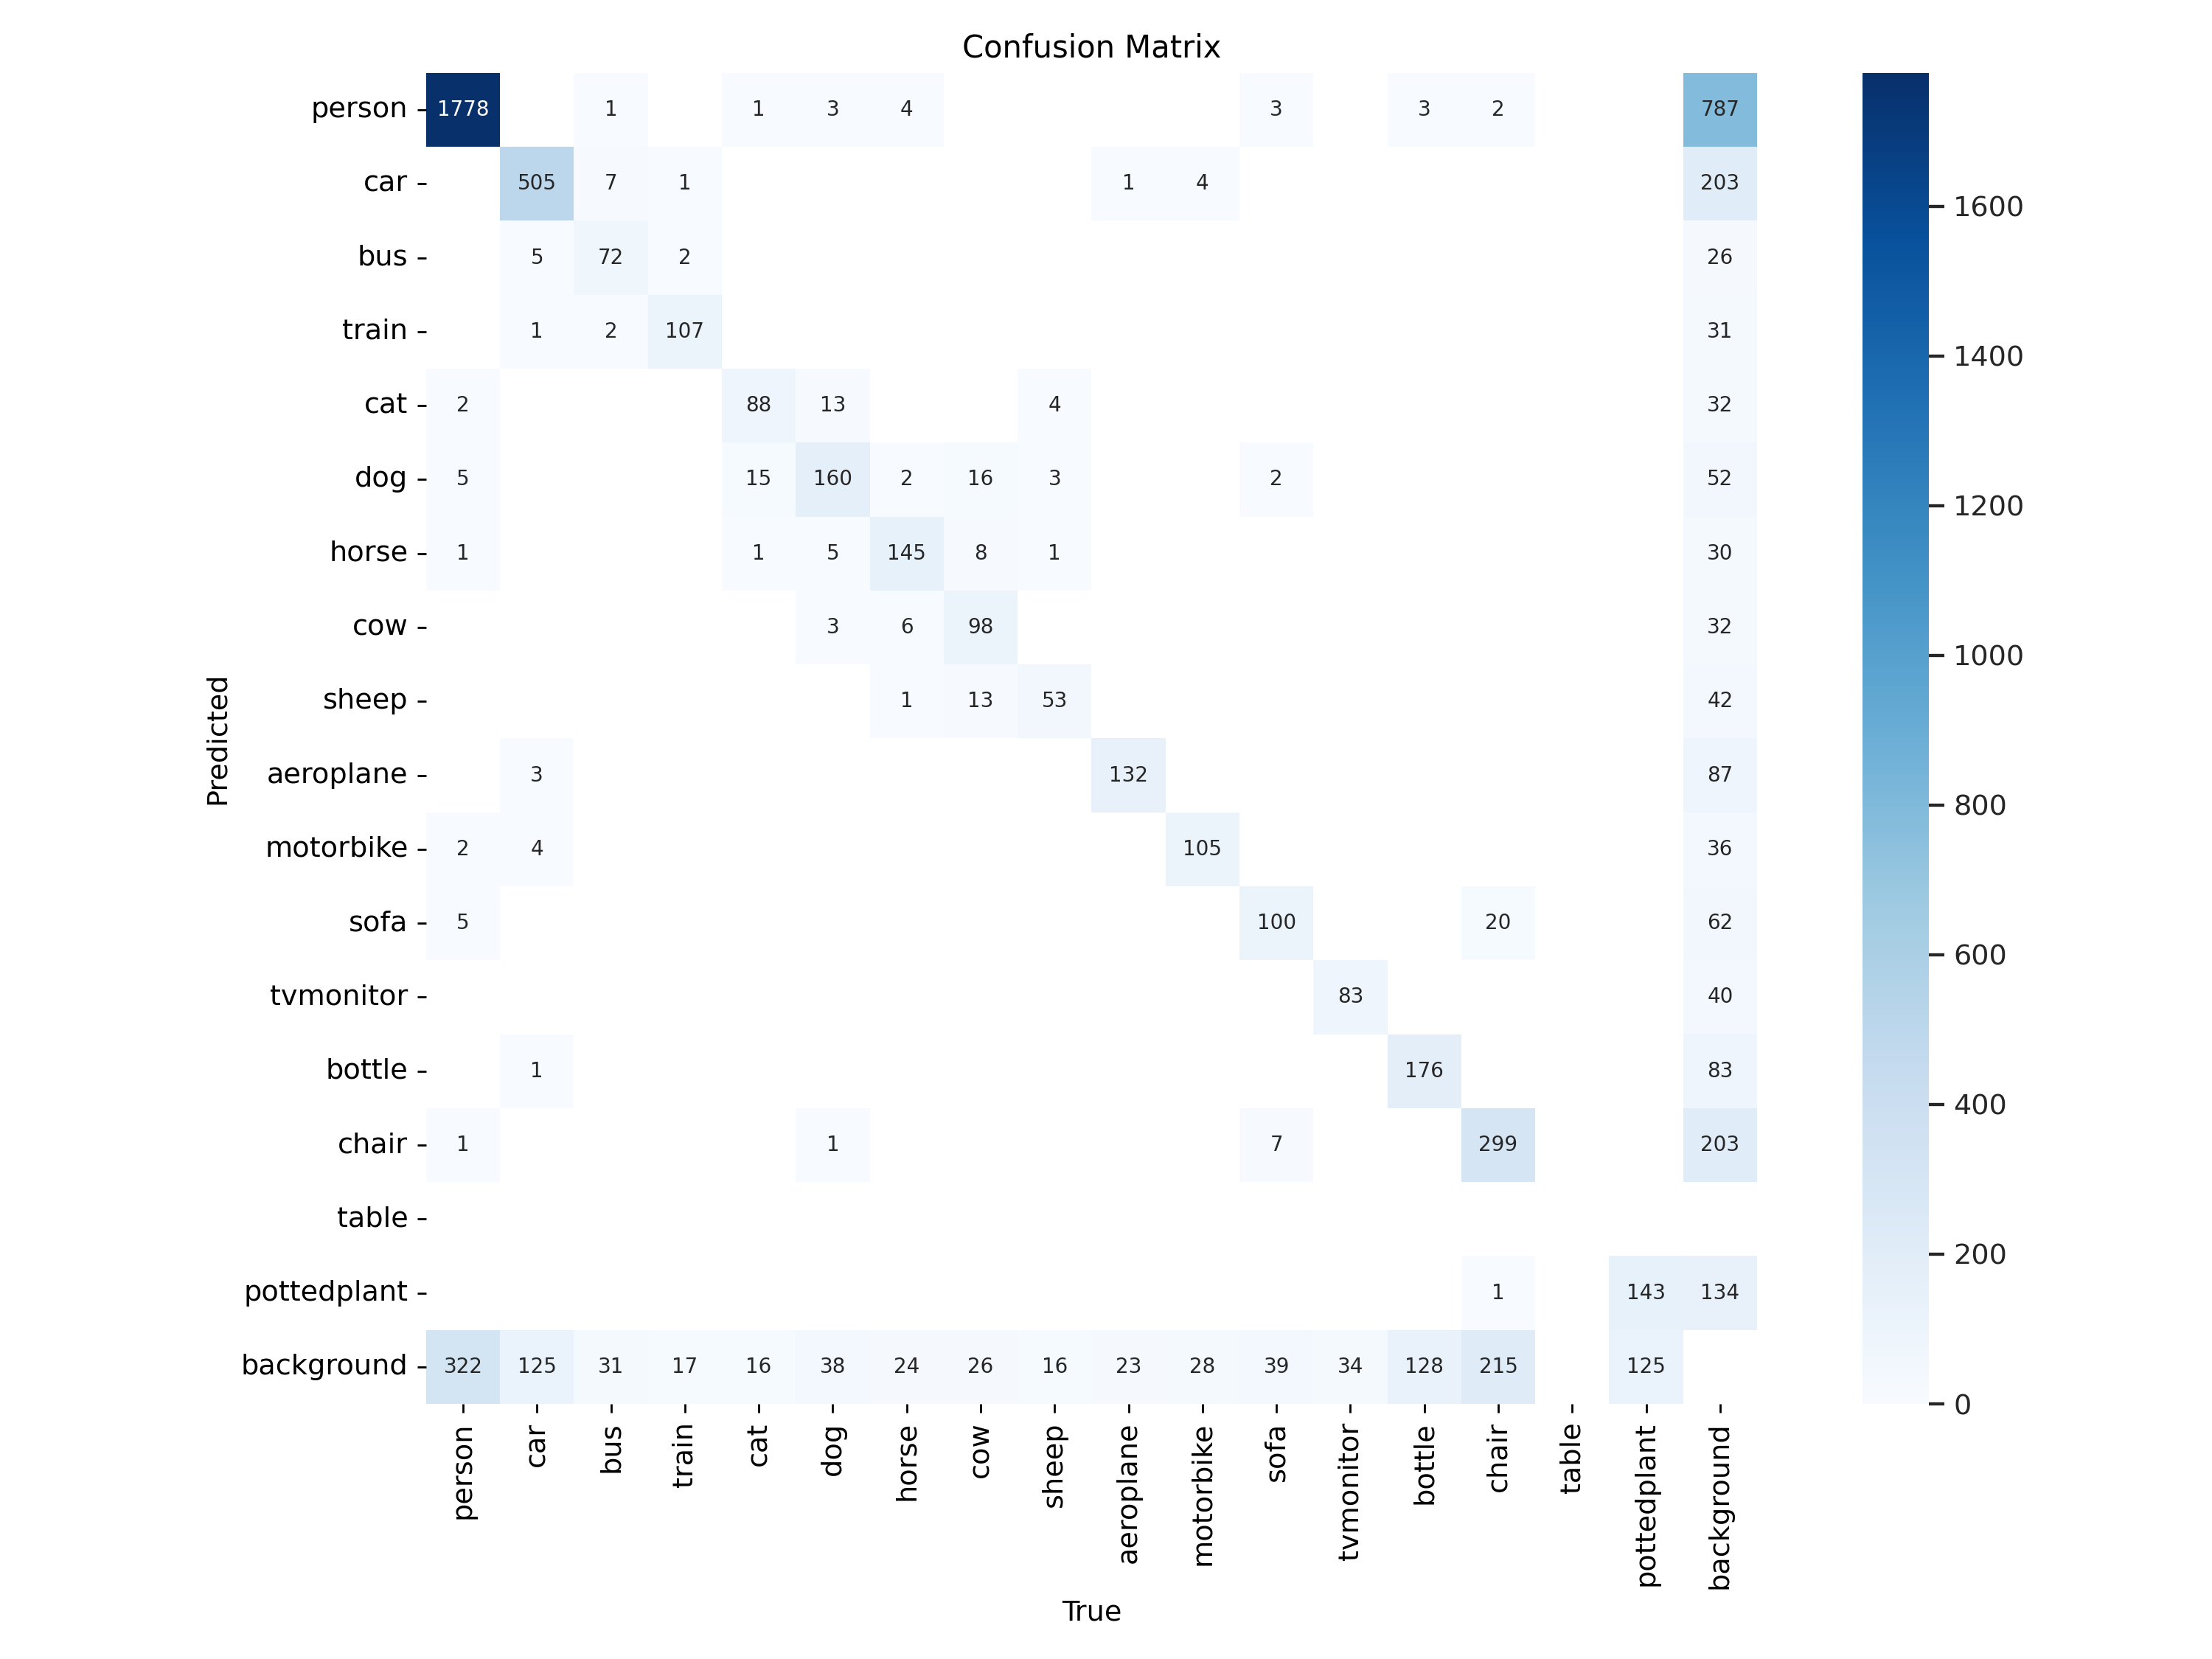

In [75]:
Image.open("/content/runs/detect/train/confusion_matrix.png")

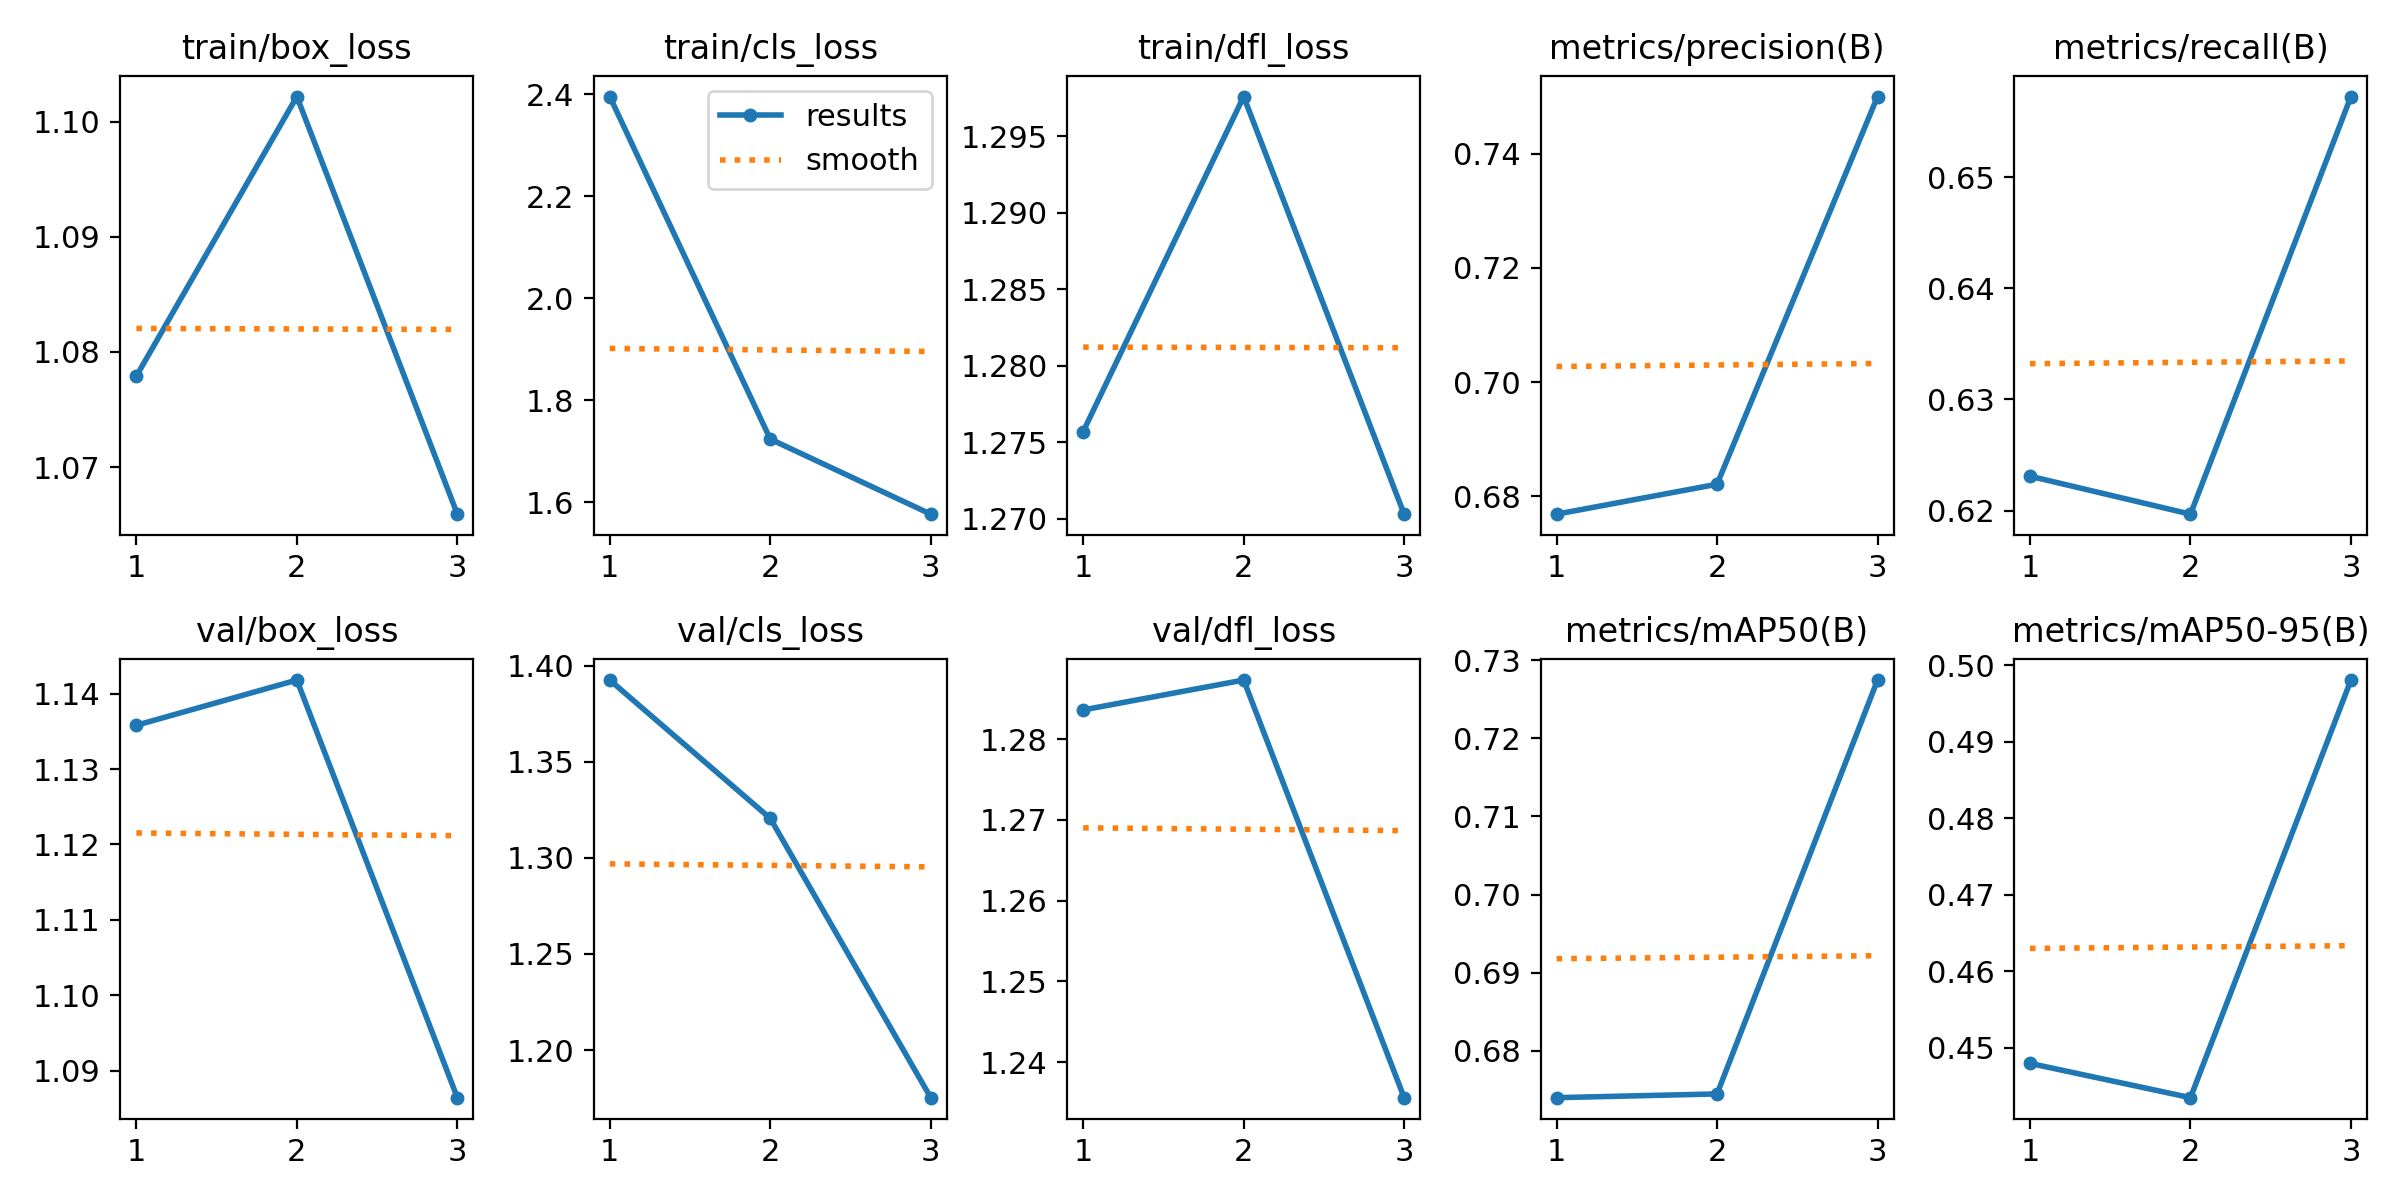

In [76]:
Image.open("/content/runs/detect/train/results.png")

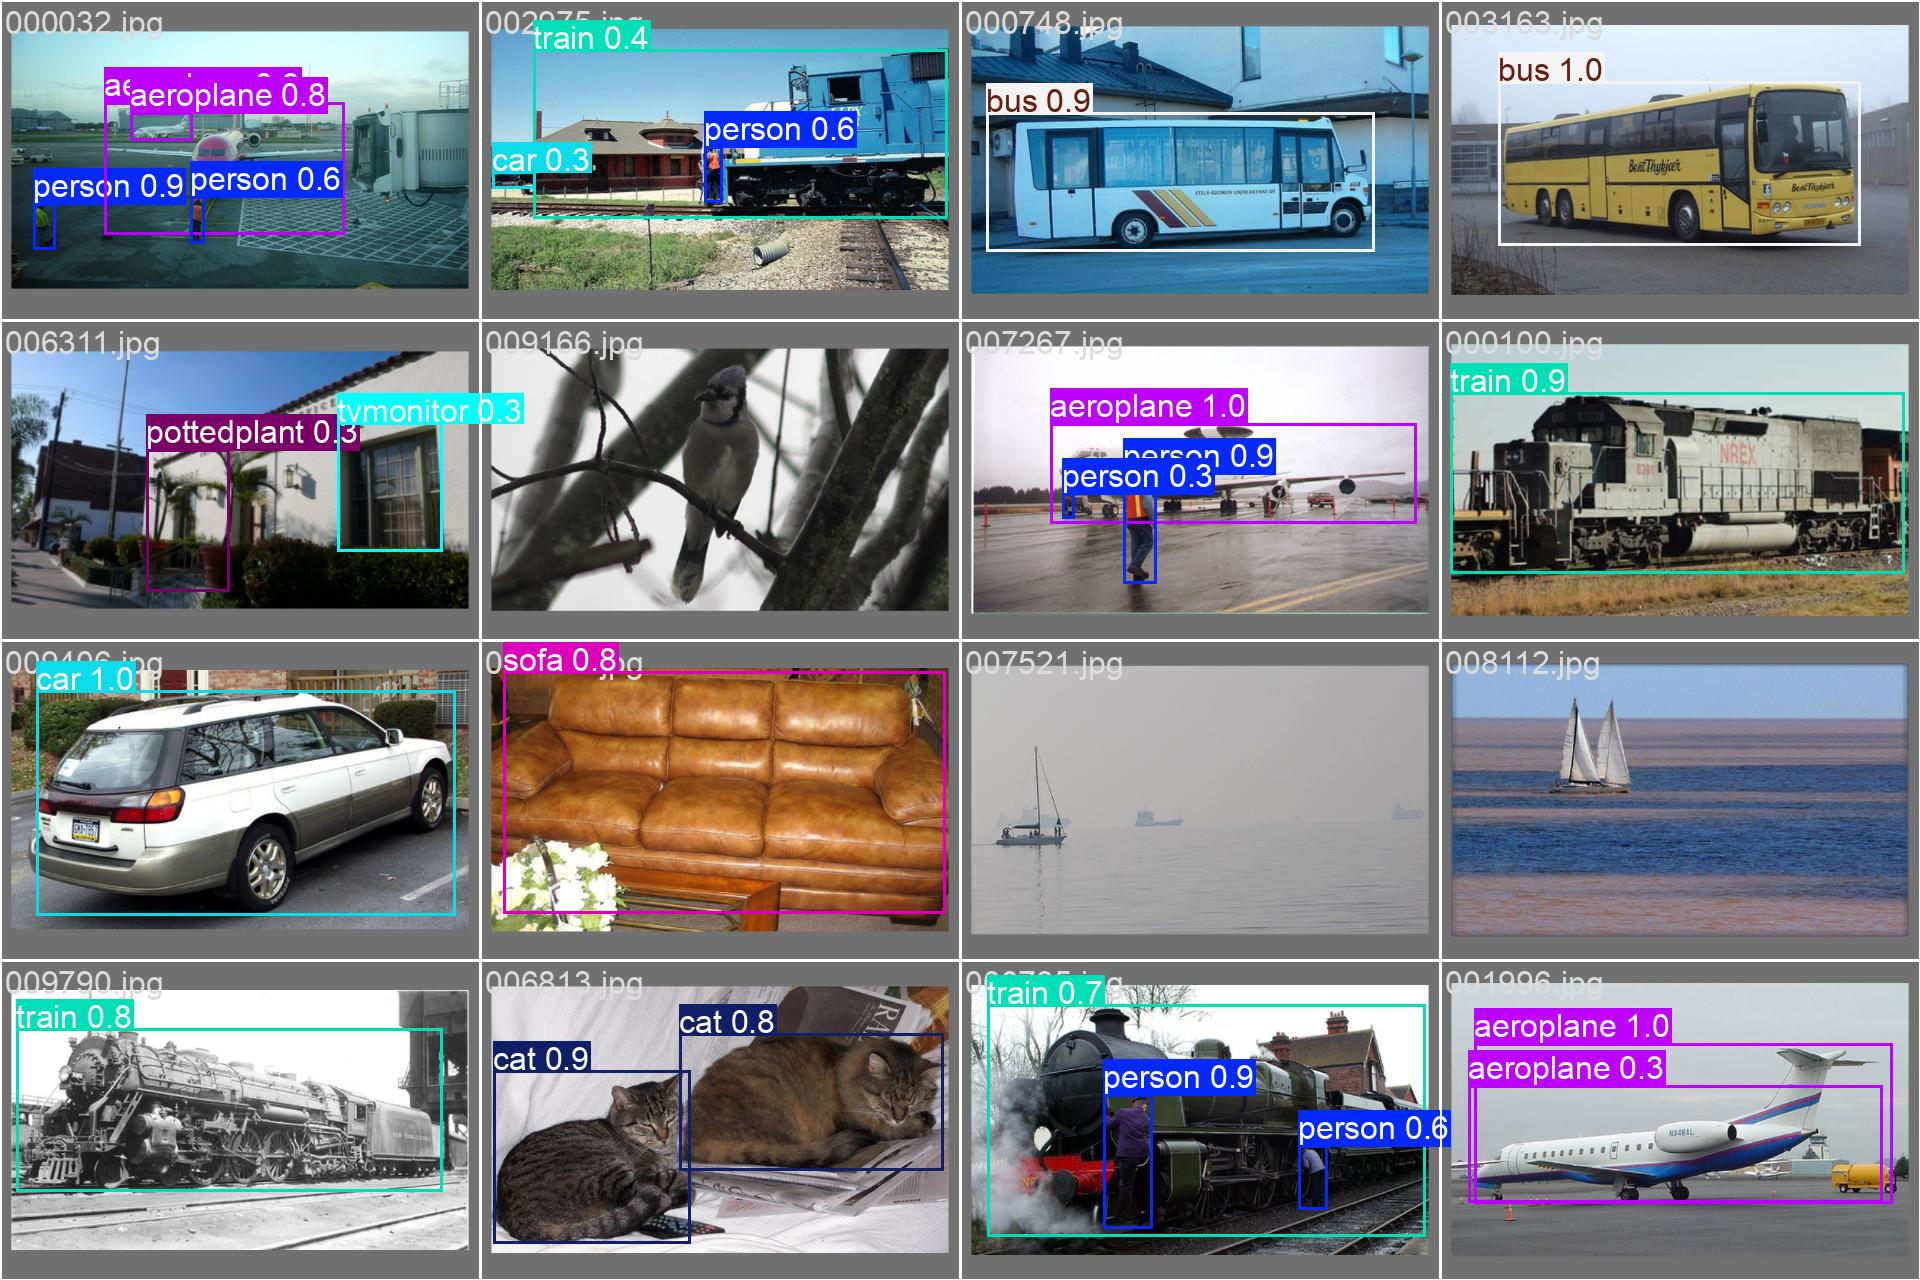

In [77]:
Image.open("/content/runs/detect/train/val_batch1_pred.jpg")